# Potato Disease Classification with CNN
Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

This cleaned notebook is reorganized so you can run all cells from top to bottom to retrain the model.
Key additions: reproducible random seeds, class-name saving, consistent save paths for the API, and a verification cell.

### 1. Setup and Constants

In [1]:
# Basic imports and reproducibility
import os
from pathlib import Path
import random
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Reproducible seeds (will help produce consistent runs)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15  # reduced for quicker experiments, increase when satisfied

# Paths (use absolute Path to avoid relative path confusion)
ROOT = Path(r"C:/Learn Programming/Machine Learning/potato_disease")
DATA_DIR = ROOT / 'data' / 'PlantVillage'
SAVED_MODELS_DIR = ROOT / 'saved_models' / 'potatoes_model'
TF_SERVING_DIR = ROOT / 'models' / 'potatoes_model' / '1'  # matches models.config and API
CLASS_NAMES_PATH = SAVED_MODELS_DIR / 'class_names.json'
H5_API_PATH = ROOT / 'saved_models' / 'potato_disease_model.h5'  # path expected by api/main.py

# Create dirs if needed
os.makedirs(SAVED_MODELS_DIR, exist_ok=True)
os.makedirs(TF_SERVING_DIR, exist_ok=True)

print('DATA_DIR ->', DATA_DIR)
print('Saved models ->', SAVED_MODELS_DIR)

DATA_DIR -> C:\Learn Programming\Machine Learning\potato_disease\data\PlantVillage
Saved models -> C:\Learn Programming\Machine Learning\potato_disease\saved_models\potatoes_model


### 2. Load Dataset and Inspect Classes
We use image_dataset_from_directory which automatically assigns labels based on folder names. We will check class counts to ensure no severe imbalance.

In [2]:
# Create a dataset (shuffle=True for training; later we will split by batches)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    str(DATA_DIR),
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

class_names = dataset.class_names
n_classes = len(class_names)
print('Detected classes (in dataset order):', class_names)

# Quick class balance check: count files per class folder
counts = {}
for p in sorted(DATA_DIR.iterdir()):
    if p.is_dir():
        counts[p.name] = len(list(p.glob('*.jpg'))) + len(list(p.glob('*.jpeg'))) + len(list(p.glob('*.png')))
print('Class counts (approx):', counts)

Found 2152 files belonging to 3 classes.
Detected classes (in dataset order): ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Class counts (approx): {'Potato___Early_blight': 1000, 'Potato___healthy': 152, 'Potato___Late_blight': 1000}
Detected classes (in dataset order): ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Class counts (approx): {'Potato___Early_blight': 1000, 'Potato___healthy': 152, 'Potato___Late_blight': 1000}


### 3. Visualize and Split Data
Visual checks help find label mismatches or corrupted images. We will split the dataset by batch index to keep things simple.

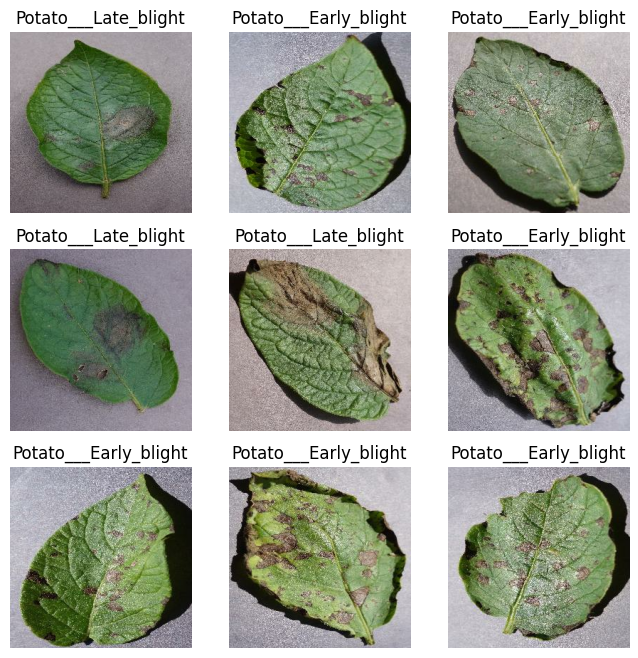

Total batches: 68, train: 54, val: 6, test: 8


In [3]:
# Visualize a few samples
plt.figure(figsize=(8, 8))
for images, labels in dataset.take(1):
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(labels[i])])
        plt.axis('off')
plt.show()

# Split dataset by batches (simple and works with tf.data.Dataset)
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    print(f"Total batches: {ds_size}, train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Prefetch/caching for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### 4. Model Definition and Training
We include a Rescaling layer in the model so the API can send raw 0-255 images directly.

In [4]:
def create_model():
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    data_augmentation = models.Sequential([
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomRotation(0.1),
    ])
    model = models.Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPool2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPool2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

c:\Learn Programming\Machine Learning\potato_disease\myenv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 776ms/step - accuracy: 0.7159 - loss: 0.8970 - val_accuracy: 0.8281 - val_loss: 0.5128
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 776ms/step - accuracy: 0.7159 - loss: 0.8970 - val_accuracy: 0.8281 - val_loss: 0.5128
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 740ms/step - accuracy: 0.8681 - loss: 0.3672 - val_accuracy: 0.8854 - val_loss: 0.2779
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 740ms/step - accuracy: 0.8681 - loss: 0.3672 - val_accuracy: 0.8854 - val_loss: 0.2779
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 715ms/step - accuracy: 0.8640 - loss: 0.3438 - val_accuracy: 0.9271 - val_loss: 0.2333
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 715ms/step - accuracy: 0.8640 - loss: 0.3438 - val_accuracy: 0.9271 - val_loss: 0.2333
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 720ms/step - accuracy: 0.8953 - loss: 0.2765 - val_accuracy: 0.9010 - val_loss: 0.2295
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 720ms/step - accuracy: 0.8953 - loss: 0.2765 - val_accu

In [6]:
# Evaluate on test set
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]:.4f}  Test Accuracy: {scores[1]:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.9440 - loss: 0.1401
Test Loss: 0.1401  Test Accuracy: 0.9440
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.9440 - loss: 0.1401
Test Loss: 0.1401  Test Accuracy: 0.9440


### 5. Save model and class names
We save both a SavedModel (for TF Serving) and an H5 file in the path `saved_models/potato_disease_model.h5` which is used by the simple API. We also write `class_names.json` so the API can use the same ordering.

In [7]:
# Save SavedModel (TF Serving compatible)
try:
    model.save(str(TF_SERVING_DIR), save_format='tf')
    print('SavedModel saved to', TF_SERVING_DIR)
except Exception as e:
    print('Error saving SavedModel:', e)

# Save Keras H5 used by the small API (api/main.py expects this path)
try:
    model.save(str(H5_API_PATH))
    print('Keras H5 saved to', H5_API_PATH)
except Exception as e:
    print('Error saving H5:', e)

# Save class names in the training order to a json file for the API to load if needed
try:
    with open(CLASS_NAMES_PATH, 'w', encoding='utf-8') as f:
        json.dump(class_names, f, ensure_ascii=False, indent=2)
    print('Saved class names to', CLASS_NAMES_PATH)
except Exception as e:
    print('Error saving class names:', e)

Error saving SavedModel: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf
Keras H5 saved to C:\Learn Programming\Machine Learning\potato_disease\saved_models\potato_disease_model.h5
Saved class names to C:\Learn Programming\Machine Learning\potato_disease\saved_models\potatoes_model\class_names.json
Keras H5 saved to C:\Learn Programming\Machine Learning\potato_disease\saved_models\potato_disease_model.h5
Saved class names to C:\Learn Programming\Machine Learning\potato_disease\saved_models\potatoes_model\class_names.json


### 6. Quick verification
Load the SavedModel or H5 and run a single sample prediction to verify the class ordering and preprocessing.

In [8]:
# pick a sample image from the dataset folders to verify
sample_img = None
for d in DATA_DIR.iterdir():
    if d.is_dir():
        files = list(d.glob('*.jpg')) + list(d.glob('*.jpeg')) + list(d.glob('*.png'))
        if files:
            sample_img = files[0]
            break

if sample_img is None:
    print('No sample image found for verification')
else:
    from PIL import Image
    img = Image.open(sample_img).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
    arr = np.array(img).astype(np.float32)
    batch = np.expand_dims(arr, 0)
    # Try loading the SavedModel first (it contains Rescaling)
    try:
        loaded = tf.keras.models.load_model(str(TF_SERVING_DIR))
        preds = loaded.predict(batch)
        print('Loaded SavedModel -> predicted:', class_names[np.argmax(preds[0])], 'conf:', np.max(preds[0]))
    except Exception as e:
        print('SavedModel load failed:', e)
        try:
            loaded = tf.keras.models.load_model(str(H5_API_PATH))
            # H5 model may include Rescaling layer as well
            preds = loaded.predict(batch)
            print('Loaded H5 -> predicted:', class_names[np.argmax(preds[0])], 'conf:', np.max(preds[0]))
        except Exception as e2:
            print('H5 load failed:', e2)

SavedModel load failed: File format not supported: filepath=C:\Learn Programming\Machine Learning\potato_disease\models\potatoes_model\1. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(C:\Learn Programming\Machine Learning\potato_disease\models\potatoes_model\1, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Loaded H5 -> predicted: Potato___Early_blight conf: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Loaded H5 -> predicted: Potato___Early_blight conf: 1.0
